Vamos a trabajar con el dataset de CallMeMaybe para brindarle información a los supervisores y las supervisores sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.
 
Inicialmente realizare el prepocesamiento y limpieza de datos para evitar datos atipicos y para entender el dataset con el que estoy trabajando.
 
Cuando ya tenga la base de datos de telecom limpia hago un merge con los datos de la base de datos de clientes
 
Despues realizaria un Analisis exploratorio de los datos para ver que tan dispersos estan.

# Inicialización

## Importacion de las librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math as mt
from scipy import stats as st
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

## Carga de datos

In [2]:
df = pd.read_csv('/datasets/telecom_dataset_us.csv')
clients = pd.read_csv('/datasets/telecom_clients_us.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [4]:
df['date']= pd.to_datetime(df['date'], format='%Y-%m-%d')

df['month']=df['date'].dt.month

In [5]:
# Identificar valores faltantes
missing_values = df.isna().sum()
print(missing_values)


user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
month                     0
dtype: int64


In [6]:
absent_values= df['operator_id'].isna()

print(df[absent_values])

       user_id                      date direction internal  operator_id  \
0       166377 2019-08-04 00:00:00+03:00        in    False          NaN   
7       166377 2019-08-05 00:00:00+03:00        in    False          NaN   
9       166377 2019-08-06 00:00:00+03:00        in    False          NaN   
17      166377 2019-08-07 00:00:00+03:00        in    False          NaN   
27      166377 2019-08-12 00:00:00+03:00        in    False          NaN   
...        ...                       ...       ...      ...          ...   
53876   168601 2019-11-27 00:00:00+03:00        in    False          NaN   
53880   168601 2019-11-28 00:00:00+03:00        in    False          NaN   
53889   168603 2019-11-28 00:00:00+03:00        in    False          NaN   
53893   168606 2019-11-08 00:00:00+03:00        in    False          NaN   
53901   168606 2019-11-19 00:00:00+03:00        in    False          NaN   

       is_missed_call  calls_count  call_duration  total_call_duration  month  
0      

Al parecer son llamadas perdidas que no se han asignado a ningun operador, quiero saber si todas son llamadas perdidas usando la informacion 'is_missed_call'.


In [7]:
# Filtra las filas donde 'operator_id' es NaN
missing_operator = df[df['operator_id'].isna()]

# Cuenta el número de llamadas perdidas en las filas con valores ausentes en 'operator_id'
num_missed_calls = missing_operator['is_missed_call'].sum()

print(f"Número de llamadas perdidas sin 'operator_id': {num_missed_calls}")

Número de llamadas perdidas sin 'operator_id': 8050


In [8]:
# Verifica si todas las filas filtradas tienen 'is_missed_call' igual a True
all_missed_calls = missing_operator['is_missed_call'].all()

print("¿Todas las llamadas sin 'operator_id' son perdidas?:", all_missed_calls)

¿Todas las llamadas sin 'operator_id' son perdidas?: False


No todas las llamadas sin operador son llamadas perdidas. De los 8172 valores ausentes en la columna 'operator_id', 8050 son llamadas perdidas. Por esta razón pienso que no seria recomendable eliminarlos ya son parte de los datos necesarios para el analisis.

In [9]:
df['operator_id'].fillna('0', inplace=True)

print(df[absent_values])

       user_id                      date direction internal operator_id  \
0       166377 2019-08-04 00:00:00+03:00        in    False           0   
7       166377 2019-08-05 00:00:00+03:00        in    False           0   
9       166377 2019-08-06 00:00:00+03:00        in    False           0   
17      166377 2019-08-07 00:00:00+03:00        in    False           0   
27      166377 2019-08-12 00:00:00+03:00        in    False           0   
...        ...                       ...       ...      ...         ...   
53876   168601 2019-11-27 00:00:00+03:00        in    False           0   
53880   168601 2019-11-28 00:00:00+03:00        in    False           0   
53889   168603 2019-11-28 00:00:00+03:00        in    False           0   
53893   168606 2019-11-08 00:00:00+03:00        in    False           0   
53901   168606 2019-11-19 00:00:00+03:00        in    False           0   

       is_missed_call  calls_count  call_duration  total_call_duration  month  
0                Tr

Reemplazamos el valor NaN en la columna 'operator_id' por 0

Por otro lado, revisemos que pasa si se eliminan los valores ausentes de la columna 'internal'

In [10]:
internal_missing_values_percentage = df['internal'].isna().sum() /df['internal'].shape[0]*100

internal_missing_values_percentage

0.21706059144373122

Si se elimina los datos ausentes de la columna 'internal' se perdería unicamente 0.21% del total lineas o llamadas por lo que no afectaría en gran medida los resultados del analisis.


In [11]:
df = df.dropna(subset=['internal'])

print(df.isna().sum())

print(df.shape)

print(df.info())

df.describe()


user_id                0
date                   0
direction              0
internal               0
operator_id            0
is_missed_call         0
calls_count            0
call_duration          0
total_call_duration    0
month                  0
dtype: int64
(53785, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 53785 entries, 0 to 53901
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              53785 non-null  int64                                
 1   date                 53785 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            53785 non-null  object                               
 3   internal             53785 non-null  object                               
 4   operator_id          53785 non-null  object                               
 5   is_missed_call       53785 non-null  bool          

,user_id,calls_count,call_duration,total_call_duration,month
count,53785.000000,53785.000000,53785.000000,53785.000000,53785.000000
mean,167294.939630,16.482681,868.436162,1159.476174,10.192080
std,598.998532,62.981680,3735.653323,4407.963966,0.851636
min,166377.000000,1.000000,0.000000,0.000000,8.000000
25%,166782.000000,1.000000,0.000000,47.000000,10.000000
50%,167162.000000,4.000000,38.000000,211.000000,10.000000
75%,167819.000000,12.000000,574.000000,905.000000,11.000000
max,168606.000000,4817.000000,144395.000000,166155.000000,11.000000


In [12]:
duplicates =df.duplicated().sum()
print(duplicates)

duplicated_rows = df[df.duplicated()]  

duplicated_rows


4893


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,month
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50,8
28,166377,2019-08-12 00:00:00+03:00,in,False,0,True,2,0,34,8
44,166377,2019-08-14 00:00:00+03:00,out,False,880026.0,False,10,1567,1654,8
45,166377,2019-08-14 00:00:00+03:00,in,False,0,True,1,0,3,8
51,166377,2019-08-15 00:00:00+03:00,out,False,880026.0,False,11,1413,1473,8
...,...,...,...,...,...,...,...,...,...,...
53869,168601,2019-11-25 00:00:00+03:00,in,False,952914.0,False,7,1229,1282,11
53874,168601,2019-11-26 00:00:00+03:00,in,False,952914.0,False,4,539,562,11
53875,168601,2019-11-26 00:00:00+03:00,in,False,0,True,3,0,35,11
53885,168603,2019-11-20 00:00:00+03:00,out,False,959118.0,True,3,0,89,11


Hay 4893 llamadas que son consideradas como duplicadas. Vamos a mantener unicamente la primera ocurrencia ya que la probabilidad de que los datos sean iguales y las llamadas sean diferentes es muy baja.

In [13]:
df = df.drop_duplicates(keep='first')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48892 entries, 0 to 53901
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              48892 non-null  int64                                
 1   date                 48892 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            48892 non-null  object                               
 3   internal             48892 non-null  object                               
 4   operator_id          48892 non-null  object                               
 5   is_missed_call       48892 non-null  bool                                 
 6   calls_count          48892 non-null  int64                                
 7   call_duration        48892 non-null  int64                                
 8   total_call_duration  48892 non-null  int64                                
 9   month 

In [14]:
num_operators = df['operator_id'].nunique()

num_operators


1093

Tenemos 1093 operadores para atender todas las llamadas de los clientes.

## Enriquecer los datos

In [15]:
df['waiting_time'] = df['total_call_duration'] - df ['call_duration']

df

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,month,waiting_time
0,166377,2019-08-04 00:00:00+03:00,in,False,0,True,2,0,4,8,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5,8,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1,8,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18,8,8
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25,8,25
...,...,...,...,...,...,...,...,...,...,...,...
53896,168606,2019-11-10 00:00:00+03:00,out,True,957922.0,False,1,0,25,11,25
53897,168606,2019-11-10 00:00:00+03:00,out,True,957922.0,True,1,0,38,11,38
53898,168606,2019-11-11 00:00:00+03:00,out,True,957922.0,False,2,479,501,11,22
53899,168606,2019-11-15 00:00:00+03:00,out,True,957922.0,False,4,3130,3190,11,60


# Telecom clients


In [16]:
clients.info()

clients

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16
...,...,...,...
727,166554,B,2019-08-08
728,166911,B,2019-08-23
729,167012,B,2019-08-28
730,166867,B,2019-08-22


In [17]:
clients.isna().sum()

user_id        0
tariff_plan    0
date_start     0
dtype: int64

In [18]:
clients.duplicated().sum()

0

El dataset clients no contiene ningun valor ausente o duplicado. 


In [19]:
# convertimos la columna date al tipo de datos correcto
clients['date_start']= pd.to_datetime(clients['date_start'], format='%Y-%m-%d')

clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


## Merge de los dataframes

In [20]:

df_merged = df.merge(clients, on ='user_id', how ='outer')

df_merged


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,month,waiting_time,tariff_plan,date_start
0,166377,2019-08-04 00:00:00+03:00,in,False,0,True,2.0,0.0,4.0,8.0,4.0,B,2019-08-01
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3.0,0.0,5.0,8.0,5.0,B,2019-08-01
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1.0,0.0,1.0,8.0,1.0,B,2019-08-01
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1.0,10.0,18.0,8.0,8.0,B,2019-08-01
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3.0,0.0,25.0,8.0,25.0,B,2019-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49312,166815,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,2019-08-20
49313,166702,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,2019-08-15
49314,166911,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,2019-08-23
49315,166867,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,2019-08-22


In [21]:
df_merged.isna().sum()



user_id                  0
date                   425
direction              425
internal               425
operator_id            425
is_missed_call         425
calls_count            425
call_duration          425
total_call_duration    425
month                  425
waiting_time           425
tariff_plan              0
date_start               0
dtype: int64

In [22]:
df_merged = df_merged.dropna()

print(df_merged.isna().sum())

user_id                0
date                   0
direction              0
internal               0
operator_id            0
is_missed_call         0
calls_count            0
call_duration          0
total_call_duration    0
month                  0
waiting_time           0
tariff_plan            0
date_start             0
dtype: int64


In [23]:
muestra_1 = df_merged[df_merged['user_id']==	166377]

muestra_1


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,month,waiting_time,tariff_plan,date_start
0,166377,2019-08-04 00:00:00+03:00,in,False,0,True,2.0,0.0,4.0,8.0,4.0,B,2019-08-01
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3.0,0.0,5.0,8.0,5.0,B,2019-08-01
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1.0,0.0,1.0,8.0,1.0,B,2019-08-01
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1.0,10.0,18.0,8.0,8.0,B,2019-08-01
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3.0,0.0,25.0,8.0,25.0,B,2019-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,166377,2019-11-28 00:00:00+03:00,in,False,880022.0,False,1.0,134.0,158.0,11.0,24.0,B,2019-08-01
515,166377,2019-11-28 00:00:00+03:00,out,False,880026.0,False,19.0,1923.0,2100.0,11.0,177.0,B,2019-08-01
516,166377,2019-11-28 00:00:00+03:00,out,False,880026.0,True,11.0,0.0,160.0,11.0,160.0,B,2019-08-01
517,166377,2019-11-28 00:00:00+03:00,in,False,880028.0,False,1.0,52.0,62.0,11.0,10.0,B,2019-08-01


In [24]:
print(df_merged.describe())



             user_id   calls_count  call_duration  total_call_duration  \
count   48892.000000  48892.000000   48892.000000         48892.000000   
mean   167294.492841     16.495214     868.088788          1158.976458   
std       598.675508     63.671633    3779.549967          4456.180933   
min    166377.000000      1.000000       0.000000             0.000000   
25%    166782.000000      1.000000       0.000000            46.000000   
50%    167158.000000      4.000000      37.000000           210.000000   
75%    167819.000000     12.000000     573.000000           902.000000   
max    168606.000000   4817.000000  144395.000000        166155.000000   

              month  waiting_time  
count  48892.000000  48892.000000  
mean      10.192465    290.887671  
std        0.852225   1133.354018  
min        8.000000      0.000000  
25%       10.000000     17.000000  
50%       10.000000     55.000000  
75%       11.000000    200.000000  
max       11.000000  46474.000000  


In [25]:
#eliminamos las columnas que no son necesarias para graficar
df_final = df_merged.drop(['user_id', 'month'], axis=1)

df_final.describe()

,calls_count,call_duration,total_call_duration,waiting_time
count,48892.000000,48892.000000,48892.000000,48892.000000
mean,16.495214,868.088788,1158.976458,290.887671
std,63.671633,3779.549967,4456.180933,1133.354018
min,1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,46.000000,17.000000
50%,4.000000,37.000000,210.000000,55.000000
75%,12.000000,573.000000,902.000000,200.000000
max,4817.000000,144395.000000,166155.000000,46474.000000


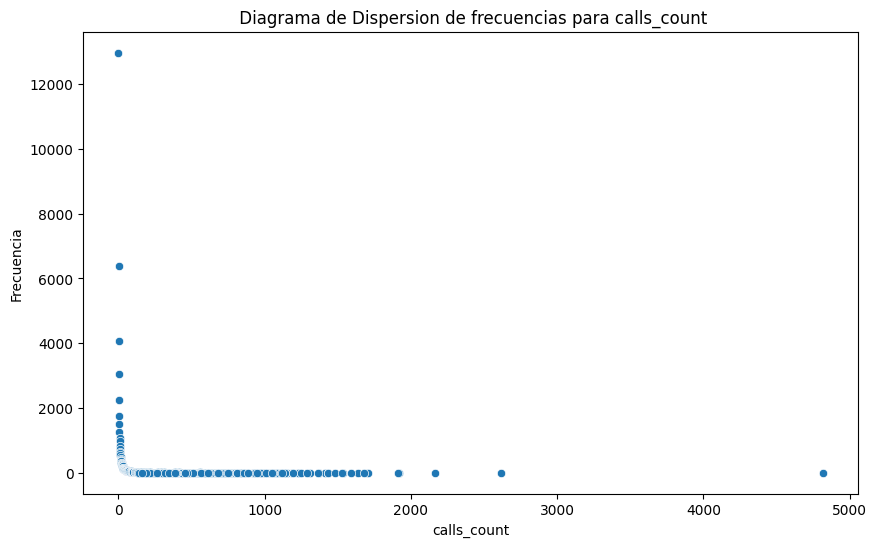

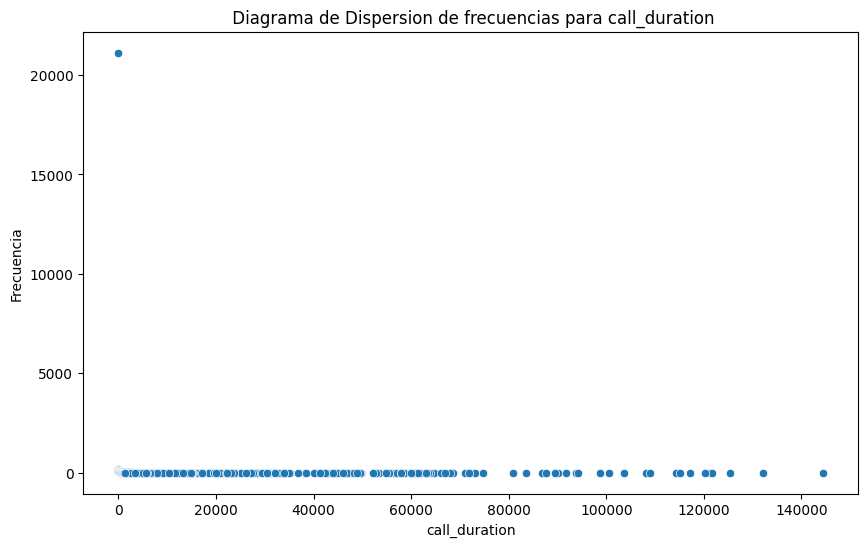

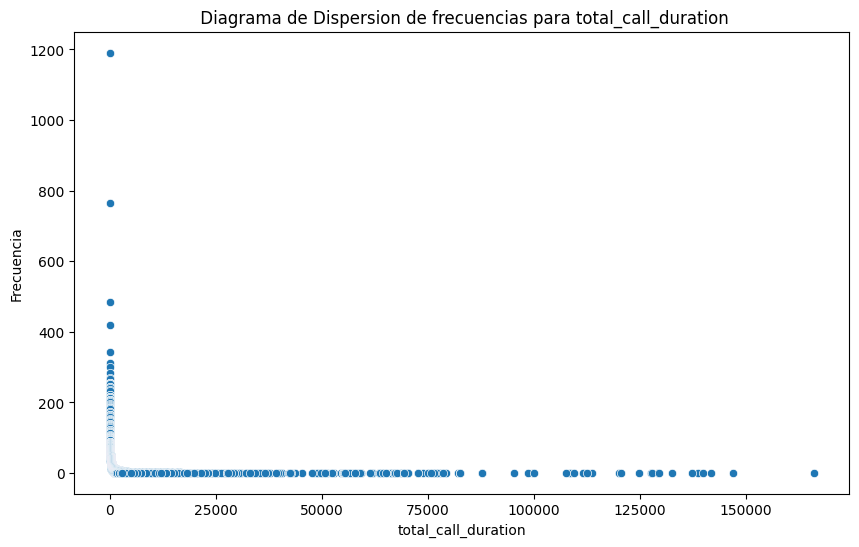

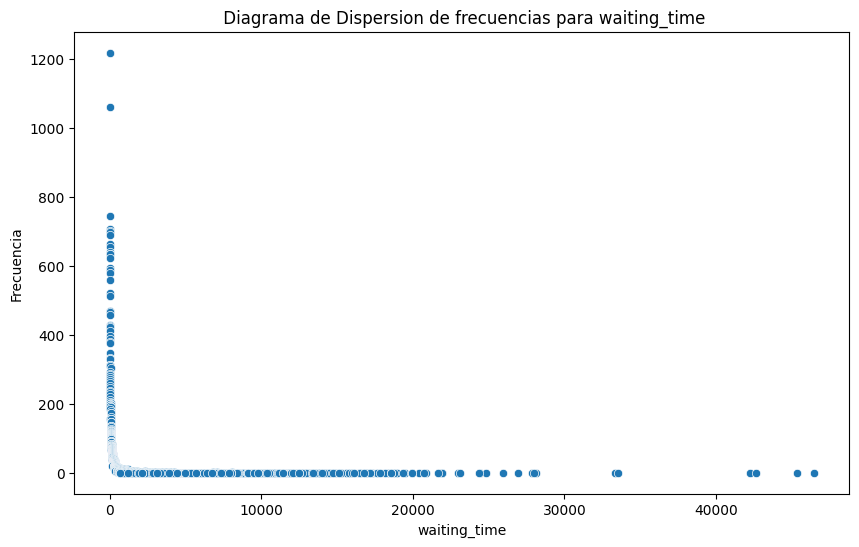

In [26]:
#Hacemos un bucle for para obtener la frecuencia de los valores de las columnas numericas
for col in df_final.select_dtypes(include="number").columns:
    frecuencia = df_final[col].value_counts().reset_index()
    frecuencia.columns = [col, "frecuencia"]
    #creamos un scatter plot de la frecuencia de cada columna
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=frecuencia, x=col, y='frecuencia')
    plt.title(f" Diagrama de Dispersion de frecuencias para {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()

Como se puede ver en las 4 columnas graficadas tenemos valores atipicos considerables. Debemos filtrar estos valores atipicos para poder continuar con el análisis.

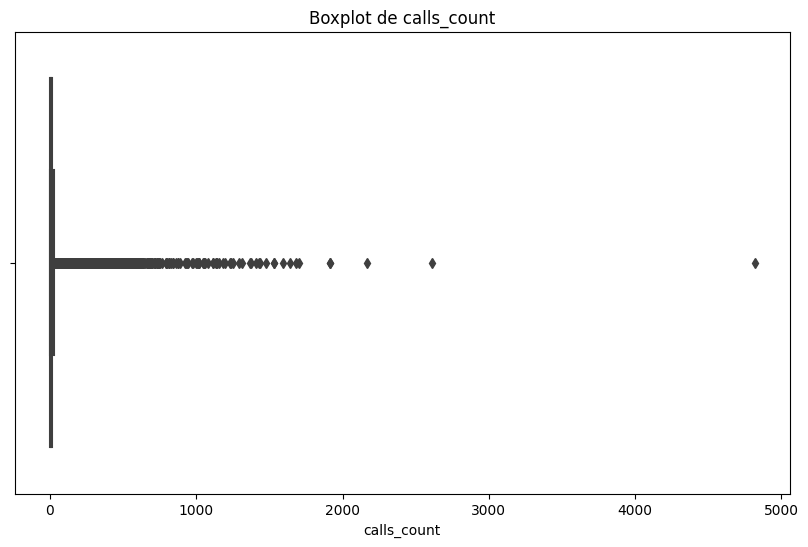

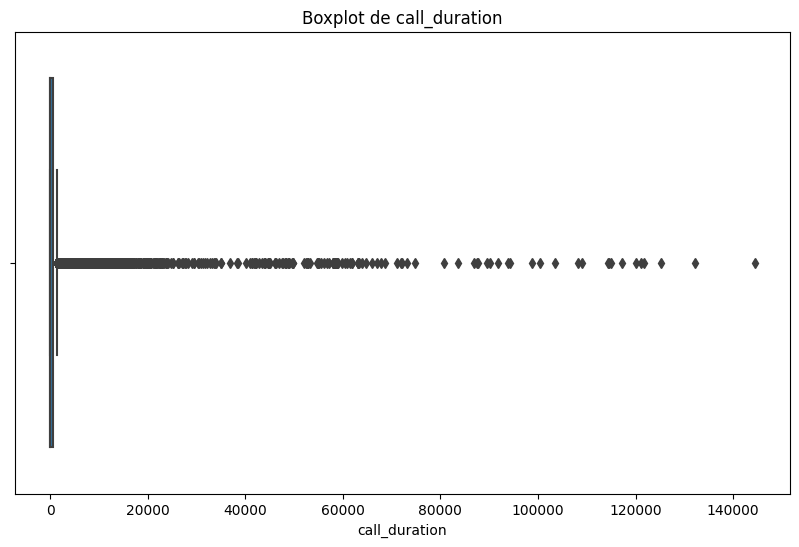

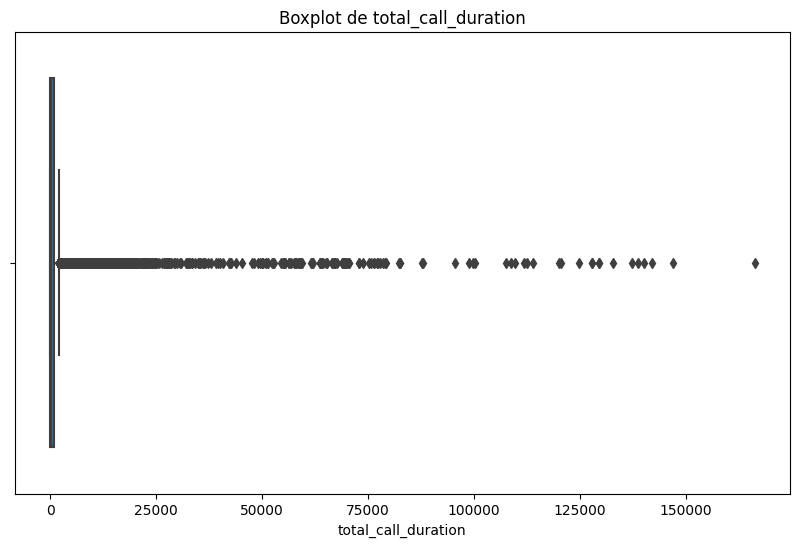

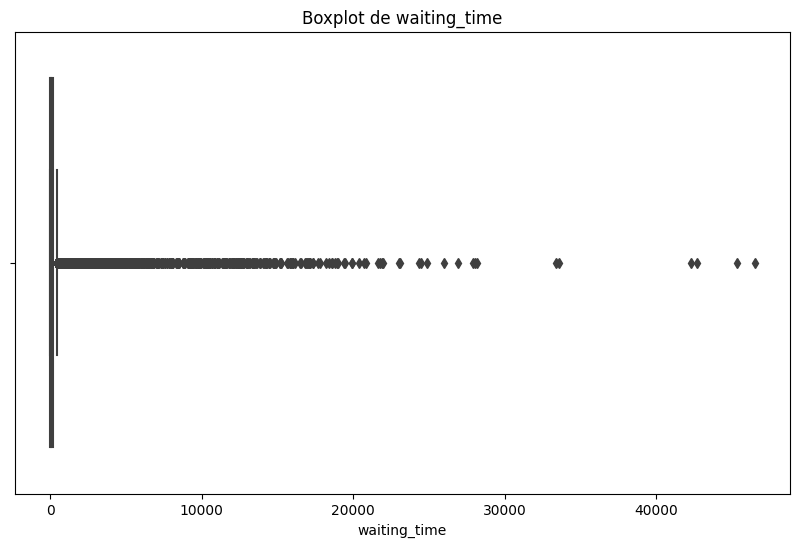

In [27]:
#Boxplot para identificar los valores atipicos

for col in df_final.select_dtypes(include="number").columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(x=df_final[col])
    plt.title(f"Boxplot de {col}")
    plt.show()

In [28]:
z_score = st.zscore(df_final.select_dtypes("number"))

z_score



,calls_count,call_duration,total_call_duration,waiting_time
0,-0.227658,-0.229683,-0.259188,-0.253134
1,-0.211952,-0.229683,-0.258964,-0.252252
2,-0.243364,-0.229683,-0.259861,-0.255781
3,-0.243364,-0.227037,-0.256046,-0.249605
4,-0.211952,-0.229683,-0.254475,-0.234605
...,...,...,...,...
48887,-0.243364,-0.229683,-0.254475,-0.234605
48888,-0.243364,-0.229683,-0.251558,-0.223134
48889,-0.227658,-0.102947,-0.147656,-0.237252
48890,-0.196247,0.598467,0.455781,-0.203723


In [52]:
filtered_entries  =(z_score < 1).all(axis=1)
filtered_df_final = df_final[filtered_entries]

print(filtered_df_final.describe())

print(filtered_df_final.isna().sum())



        calls_count  call_duration  total_call_duration  waiting_time
count  45746.000000   45746.000000         45746.000000  45746.000000
mean       8.253989     438.938639           577.566716    138.628077
std       11.695127     827.646396           922.060233    221.871430
min        1.000000       0.000000             0.000000      0.000000
25%        1.000000       0.000000            42.000000     16.000000
50%        3.000000      32.000000           173.000000     48.000000
75%       10.000000     470.000000           671.000000    156.000000
max       80.000000    4647.000000          5601.000000   1424.000000
date                   0
direction              0
internal               0
operator_id            0
is_missed_call         0
calls_count            0
call_duration          0
total_call_duration    0
waiting_time           0
tariff_plan            0
date_start             0
dtype: int64


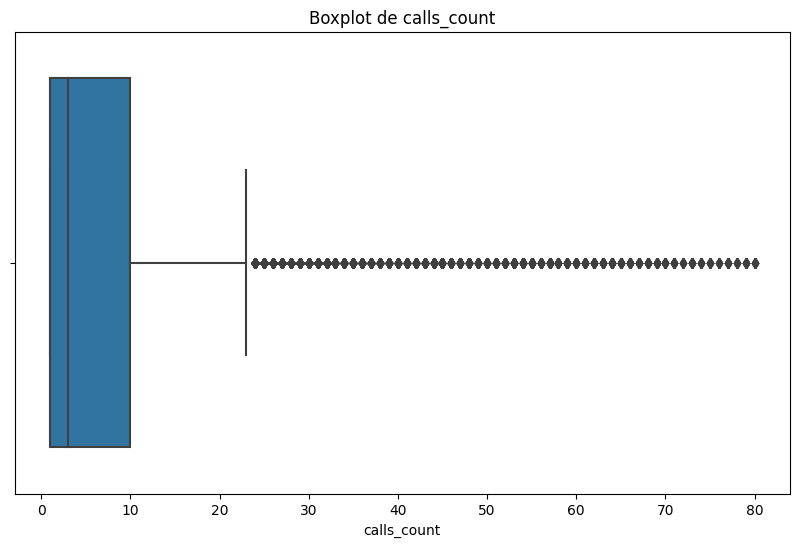

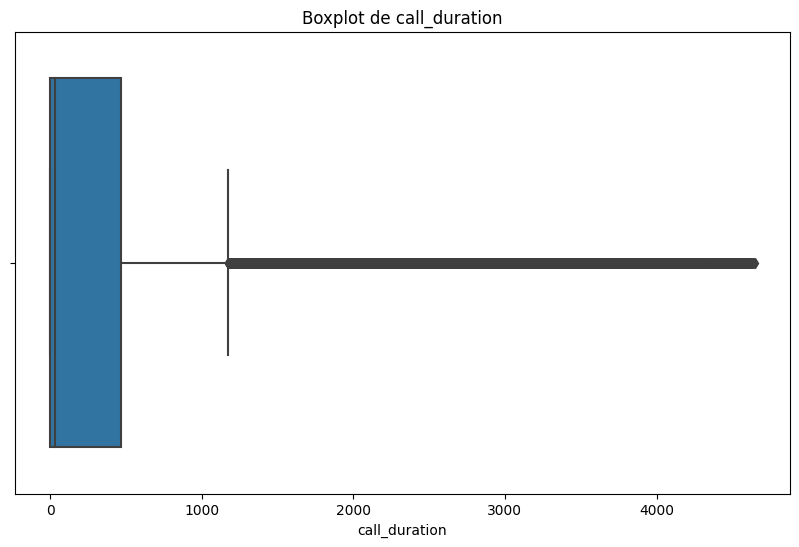

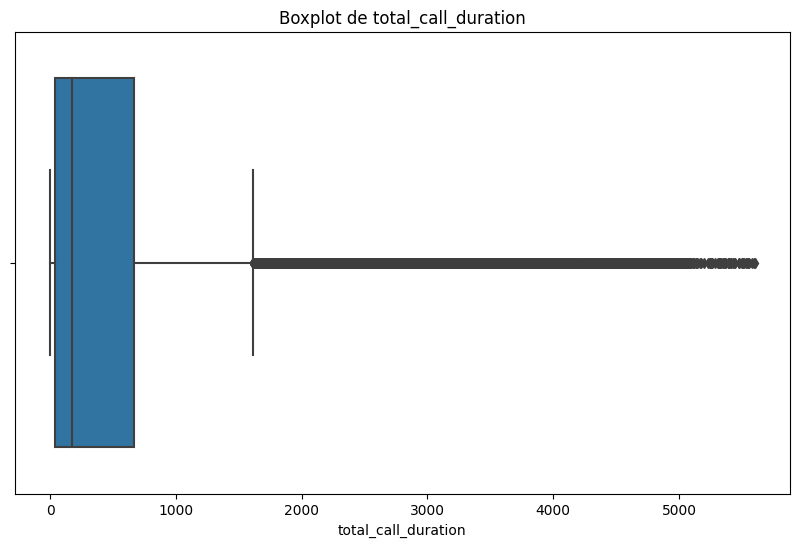

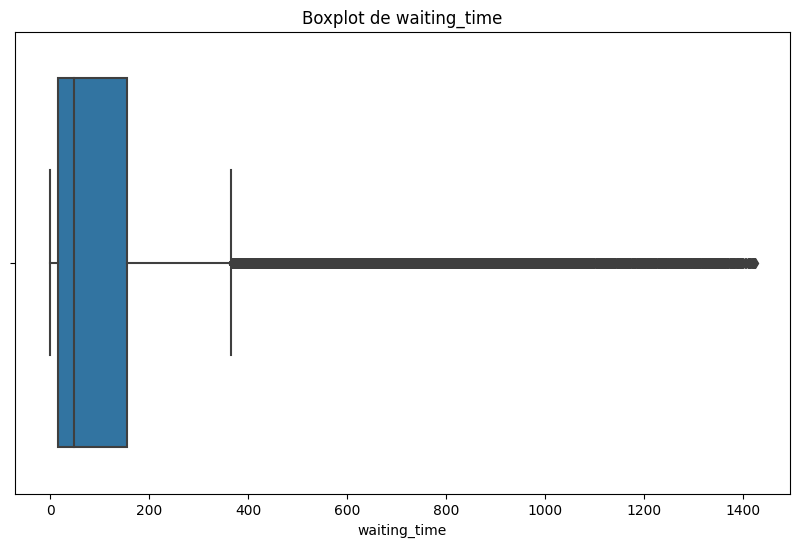

In [30]:
#Boxplot para identificar los valores atipicos
for col in filtered_df_final.select_dtypes(include="number").columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(x=filtered_df_final[col])
    plt.title(f"Boxplot de {col}")
    plt.show()

In [31]:
avg_waiting_time =df_merged.groupby('operator_id')['waiting_time'].mean().reset_index()

avg_waiting_time.columns = ['operator_id', 'avg_waiting_time']

print(avg_waiting_time)

avg_waiting_time_total = df_merged['waiting_time'].mean()

print(avg_waiting_time_total)

     operator_id  avg_waiting_time
0       879896.0        104.914530
1       879898.0        459.690265
2       880020.0         14.000000
3       880022.0         53.971429
4       880026.0        121.978022
...          ...               ...
1088    972412.0        210.000000
1089    972460.0         88.571429
1090    973120.0         10.000000
1091    973286.0         88.000000
1092           0        171.333739

[1093 rows x 2 columns]
290.8876707845864


Encontramos el tiempo promedio de espera en llamada 290 segundos

In [32]:
# Filtra las llamadas entrantes
incoming_calls = df_merged[df_merged['direction'] == 'in']

# Calcula el número de llamadas perdidas por operador
missed_calls = incoming_calls[incoming_calls['is_missed_call'] == True]
missed_calls_count = missed_calls.groupby('operator_id')['calls_count'].sum().reset_index()
missed_calls_count.columns = ['operator_id', 'missed_calls_count']

missed_calls_count

,operator_id,missed_calls_count
0,882680.0,3.0
1,882684.0,4.0
2,882686.0,6.0
3,882690.0,2.0
4,884408.0,4.0
...,...,...
235,960620.0,1.0
236,964510.0,2.0
237,964666.0,3.0
238,969272.0,1.0


Encontramos las llamadas perdidas por usuario y podemos ver que las llamadas perdidas sin operador son 103238.

In [33]:
# Unir ambas métricas (llamadas perdidas y tiempo de espera promedio)
ineffective_operators = pd.merge(missed_calls_count, avg_waiting_time, on='operator_id').sort_values(by='missed_calls_count', ascending=False)

ineffective_operators

,operator_id,missed_calls_count,avg_waiting_time
239,0,103238.0,171.333739
98,913942.0,52.0,282.948148
210,944226.0,30.0,106.784091
196,940588.0,30.0,112.691176
6,885890.0,26.0,5703.565217
...,...,...,...
139,926490.0,1.0,47.333333
34,897872.0,1.0,11.965517
137,925826.0,1.0,93.109091
136,924960.0,1.0,36.111940


Aca podemos ver que hay muchas llamadas (103238) a las que no se les asigna un operador, lo que es una oportunidad de mejora muy grande. Dejare por fuera para encontrar el promedio de llamadas perdidas ya que si lo dejo esto sesgaria los resultados.

In [34]:
innefective_operators_incoming_calls = ineffective_operators[ineffective_operators['operator_id']!= '0'] 

avg_missed_calls_operator = innefective_operators_incoming_calls.groupby('operator_id')['missed_calls_count'].mean().reset_index()

avg_missed_calls_operator.columns= ['operator_id', 'avg_missed_calls_count']

print(avg_missed_calls_operator)

avg_missed_calls = avg_missed_calls_operator['avg_missed_calls_count'].mean()

print(avg_missed_calls)

innefective_operators_incoming_calls

     operator_id  avg_missed_calls_count
0       882680.0                     3.0
1       882684.0                     4.0
2       882686.0                     6.0
3       882690.0                     2.0
4       884408.0                     4.0
..           ...                     ...
234     959312.0                     7.0
235     960620.0                     1.0
236     964510.0                     2.0
237     964666.0                     3.0
238     969272.0                     1.0

[239 rows x 2 columns]
3.8702928870292888


,operator_id,missed_calls_count,avg_waiting_time
98,913942.0,52.0,282.948148
210,944226.0,30.0,106.784091
196,940588.0,30.0,112.691176
6,885890.0,26.0,5703.565217
179,937956.0,24.0,17.150000
...,...,...,...
139,926490.0,1.0,47.333333
34,897872.0,1.0,11.965517
137,925826.0,1.0,93.109091
136,924960.0,1.0,36.111940


Encontramos que el promedio de llamadas perdidas totales es 3.87 llamadas. Podemos establecer estos 2 promedios como umbrales para encontrar los operadores ineficaces.

In [35]:
# Define umbrales para identificar operadores ineficaces
missed_call_threshold = 4  
waiting_time_threshold = 290  

# Filtra los operadores que superen ambos umbrales
innefective_operators_incoming_calls = innefective_operators_incoming_calls[
    (innefective_operators_incoming_calls['missed_calls_count'] > missed_call_threshold) &
    (innefective_operators_incoming_calls['avg_waiting_time'] > waiting_time_threshold)
]

# Muestra los operadores ineficaces
print("Operadores ineficaces:")
innefective_operators_incoming_calls

Operadores ineficaces:


,operator_id,missed_calls_count,avg_waiting_time
6,885890.0,26.0,5703.565217
5,885876.0,20.0,4838.459364
199,940622.0,16.0,305.440678
97,913938.0,14.0,338.851351
150,931458.0,12.0,555.507246
113,919554.0,11.0,461.650602
204,940658.0,10.0,385.132530
138,925922.0,10.0,5805.027397
109,919204.0,9.0,429.454545
110,919206.0,9.0,388.684211


In [36]:
# Busqueda del numero de llamadas salientes 
outbound_calls = df_merged[df_merged['direction'] == 'out']

# Agrupar por operador y sumar el número de llamadas
calls_per_operator = outbound_calls.groupby('operator_id')['calls_count'].sum().reset_index().sort_values(by='calls_count',ascending=False)

# Renombrar la columna para mayor claridad
calls_per_operator.columns = ['operator_id', 'total_outgoing_calls']


calls_per_operator

,operator_id,total_outgoing_calls
25,885890.0,58977.0
24,885876.0,58437.0
466,929428.0,23754.0
446,925922.0,19603.0
255,908640.0,14239.0
...,...,...
654,941826.0,1.0
653,941816.0,1.0
298,914626.0,1.0
718,947596.0,1.0


In [37]:
muestra = calls_per_operator[calls_per_operator['operator_id']== '0'	]

muestra

,operator_id,total_outgoing_calls
882,0,515.0


In [38]:
calls_per_operator_without_0 = calls_per_operator[calls_per_operator['operator_id']!= '0'	]

calls_per_operator_without_0

,operator_id,total_outgoing_calls
25,885890.0,58977.0
24,885876.0,58437.0
466,929428.0,23754.0
446,925922.0,19603.0
255,908640.0,14239.0
...,...,...
654,941826.0,1.0
653,941816.0,1.0
298,914626.0,1.0
718,947596.0,1.0


In [39]:
avg_outbound_calls_total = calls_per_operator_without_0['total_outgoing_calls'].mean()

print(avg_outbound_calls_total)



689.7312925170068


En promedio por operador realiza 689 llamadas.

In [40]:
# Defino umbrales para identificar operadores ineficaces por llamadas salientes
outbound_calls_threshold= 100 
 

# Filtra los operadores que superen ambos umbrales
calls_per_operator_without_0 = calls_per_operator_without_0[
    (calls_per_operator_without_0['total_outgoing_calls'] < outbound_calls_threshold)]

# Muestra los operadores ineficaces
print("Operadores ineficaces:")
print(calls_per_operator_without_0)

calls_per_operator_without_0 = calls_per_operator_without_0[calls_per_operator_without_0['total_outgoing_calls']<20]


Operadores ineficaces:
    operator_id  total_outgoing_calls
389    920728.0                  99.0
496    932292.0                  97.0
115    896390.0                  97.0
205    905570.0                  96.0
274    911310.0                  95.0
..          ...                   ...
654    941826.0                   1.0
653    941816.0                   1.0
298    914626.0                   1.0
718    947596.0                   1.0
486    930816.0                   1.0

[453 rows x 2 columns]


quiero mostrar los operadores que cumplen con las dos caracteriscas, que son muchas llamadas perdidas y pocas llamadas salientes.


In [41]:
operators_with_both_issues =calls_per_operator_without_0.merge(innefective_operators_incoming_calls, on ='operator_id', how ='inner')

operators_with_both_issues

,operator_id,total_outgoing_calls,missed_calls_count,avg_waiting_time
0,919554.0,11.0,11.0,461.650602
1,919204.0,9.0,9.0,429.454545
2,919206.0,1.0,9.0,388.684211


In [42]:
#calculamos la desviacion estandar del tiempo de espera
std_wait_time = innefective_operators_incoming_calls['avg_waiting_time'].std().round(2)

#calculamos la desviacion estandar de llamadas perdidas por operador
std_missed_calls = innefective_operators_incoming_calls['missed_calls_count'].std().round(0)

#calculamos la desviacion estandar de las llamadas salientes por operador
std_outbound_calls = calls_per_operator_without_0['total_outgoing_calls'].std().round(2)

std_outbound_calls

5.39

In [43]:
print("avg_waiting_time:", avg_waiting_time_total)
print("std_wait_time:", std_wait_time)
print("avg_missed_calls:", avg_missed_calls)
print("std_missed_calls:", std_missed_calls)
print("avg_outbound_calls_total:", avg_outbound_calls_total)
print("std_outbound_calls:", std_outbound_calls)

avg_waiting_time: 290.8876707845864
std_wait_time: 1933.27
avg_missed_calls: 3.8702928870292888
std_missed_calls: 6.0
avg_outbound_calls_total: 689.7312925170068
std_outbound_calls: 5.39


## Identificar operadores ineficaces

### Establecer umbrales

In [44]:
#definimos los umbrales
threshold_waiting_time = avg_waiting_time_total + (1.5* std_wait_time)
threshold_missed_calls = avg_missed_calls + (1.5* std_missed_calls)
threshold_outbound_calls = avg_outbound_calls_total + (1.5*std_outbound_calls)

print(f"El valor del umbral de tiempo de espera es de : {threshold_waiting_time}")
print(f"El Valor del umbral de llamadas perdidas es de : {threshold_missed_calls}")
print(f"El valor del umbral de llamadas salientes es de : {threshold_outbound_calls}")

El valor del umbral de tiempo de espera es de : 3190.7926707845863
El Valor del umbral de llamadas perdidas es de : 12.870292887029288
El valor del umbral de llamadas salientes es de : 697.8162925170068


In [45]:
def detectar_operadores_ineficaces(df, avg_waiting_time_total, std_wait_time, avg_missed_calls, std_missed_calls, avg_outbound_calls_total, std_outbound_calls):
    # Calcula los umbrales
    threshold_waiting_time = avg_waiting_time_total + (1.5 * std_wait_time)
    threshold_missed_calls = avg_missed_calls + (1.5 * std_missed_calls)
    threshold_outbound_calls = avg_outbound_calls_total + (1.5 * std_outbound_calls)

    print(f"Umbral de tiempo de espera: {threshold_waiting_time}")
    print(f"Umbral de llamadas perdidas: {threshold_missed_calls}")
    print(f"Umbral de llamadas salientes: {threshold_outbound_calls}")
    
    
    
    # Contar llamadas perdidas por operador si `is_missed_call` es booleana
    df_merged.loc[:,'missed_call_count'] = df_merged.groupby('operator_id')['is_missed_call'].transform('sum')


    # Filtra los operadores que superan al menos uno de los umbrales
    operadores_ineficaces = df_merged[
        (df_merged['waiting_time'] > threshold_waiting_time) |
        (df_merged['missed_call_count'] > threshold_missed_calls) |
        (df_merged['calls_count'] > threshold_outbound_calls)
    ]

    return operadores_ineficaces

#Aplicacion de la funcion

ineficaces = detectar_operadores_ineficaces(
    df_merged,
    avg_waiting_time_total, std_wait_time,
    avg_missed_calls, std_missed_calls,
    avg_outbound_calls_total, std_outbound_calls
)

# Mostrar los operadores ineficaces
print("Operadores ineficaces:")
print(ineficaces)


# Agrupar el DataFrame 'ineficaces' por 'operator_id' para obtener los operadores ineficaces únicos
operadores_ineficaces = ineficaces.groupby('operator_id').size().reset_index(name='count')

# Obtener la lista de operadores ineficaces como una lista de valores únicos
lista = operadores_ineficaces['operator_id'].tolist()

# Imprimir la cantidad total de operadores ineficaces y la lista de operadores
print(len(lista))
print(lista)

Umbral de tiempo de espera: 3190.7926707845863
Umbral de llamadas perdidas: 12.870292887029288
Umbral de llamadas salientes: 697.8162925170068
Operadores ineficaces:
       user_id                      date direction internal operator_id  \
0       166377 2019-08-04 00:00:00+03:00        in    False           0   
1       166377 2019-08-05 00:00:00+03:00       out     True    880022.0   
4       166377 2019-08-05 00:00:00+03:00       out    False    880022.0   
7       166377 2019-08-05 00:00:00+03:00        in    False           0   
8       166377 2019-08-06 00:00:00+03:00        in    False           0   
...        ...                       ...       ...      ...         ...   
48872   168601 2019-11-28 00:00:00+03:00        in    False           0   
48873   168601 2019-11-28 00:00:00+03:00       out    False    952914.0   
48880   168603 2019-11-28 00:00:00+03:00        in    False           0   
48884   168606 2019-11-08 00:00:00+03:00        in    False           0   
48891   1

/opt/conda/envs/python3/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/envs/python3/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


encontramos que hay 379 operadores ineficaces que no estan cumpliendo con los umbrales de la empresa y sus correspondientes 'operator_id.

Específicamente, al sumar 1.5× desviacion estandar a la media, estás estableciendo un límite superior que se encuentra aproximadamente 1.5 desviaciones estándar por encima del promedio. Este enfoque es común para identificar valores que están notablemente por encima de la media, aunque no tanto como para clasificarlos como outliers extremos (que normalmente se encuentran a 2 o 3 desviaciones estándar).

<AxesSubplot:xlabel='tariff_plan', ylabel='waiting_time'>

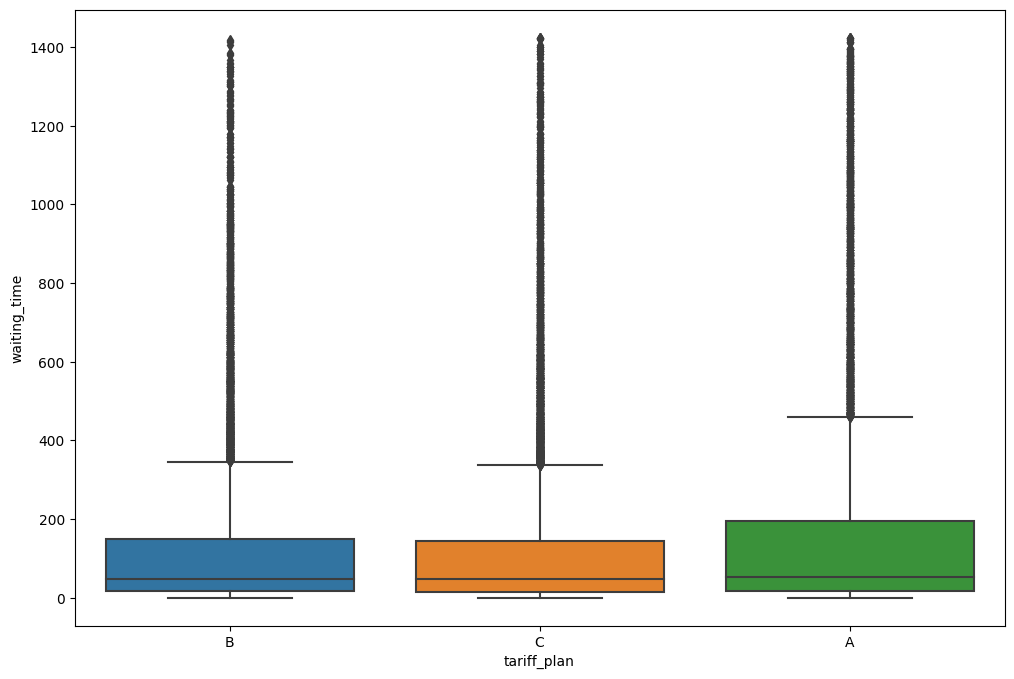

In [46]:
# Trazo un diagrama de caja para ver que tan dirpersa esta la informacion

plt.figure(figsize=(12,8))
sns.boxplot(data=filtered_df_final, x='tariff_plan', y='waiting_time')

In [47]:
mean_waiting_time = df_merged.groupby(['operator_id','tariff_plan'])['waiting_time'].mean()

mean_waiting_time.columns = ['operator_id','tariff_plan', 'avg_waiting_time']

print(mean_waiting_time)

operator_id  tariff_plan
879896.0     B              104.914530
879898.0     B              459.690265
880020.0     B               14.000000
880022.0     B               53.971429
880026.0     B              121.978022
                               ...    
973120.0     C               10.000000
973286.0     B               88.000000
0            A              323.669704
             B              159.952067
             C              120.745748
Name: waiting_time, Length: 1095, dtype: float64


## Prueba de hipótesis 


Hipótesis: Los clientes de la tarifa A esperan mas para ser atendidos que los de la tarifa C

H0:Las distribuciones del tiempo de espera de la tarifa A y la tarifa C son iguales.

H1:Las distribuciones del tiempo de espera son diferentes.

In [48]:
df_merged.describe()

,user_id,calls_count,call_duration,total_call_duration,month,waiting_time
count,48892.000000,48892.000000,48892.000000,48892.000000,48892.000000,48892.000000
mean,167294.492841,16.495214,868.088788,1158.976458,10.192465,290.887671
std,598.675508,63.671633,3779.549967,4456.180933,0.852225,1133.354018
min,166377.000000,1.000000,0.000000,0.000000,8.000000,0.000000
25%,166782.000000,1.000000,0.000000,46.000000,10.000000,17.000000
50%,167158.000000,4.000000,37.000000,210.000000,10.000000,55.000000
75%,167819.000000,12.000000,573.000000,902.000000,11.000000,200.000000
max,168606.000000,4817.000000,144395.000000,166155.000000,11.000000,46474.000000


In [49]:
#filtered_df_final =filtered_df_final[filtered_df_final['operator_id'] != 0]

tariff_a =filtered_df_final[filtered_df_final['tariff_plan'] == 'A']['waiting_time'].dropna()
                    
stat, p = shapiro(tariff_a)
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

Probably not Gaussian


/opt/conda/envs/python3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [50]:
tariff_c =filtered_df_final[filtered_df_final['tariff_plan'] == 'C']['waiting_time'].dropna()

stat, p = shapiro(tariff_c)
if p > 0.05:
	print('Probably Gaussian')
else:
	print('Probably not Gaussian')

Probably not Gaussian


Al no ser distribuciones normales o gaussianas, usamos una prueba no parametrica como lo es la Mann-Whitney U Test para ver si las distribuciones de las tarifas son iguales o no.

In [51]:
stat, p = mannwhitneyu(tariff_a, tariff_c)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=109053868.000, p=0.000
Probably different distributions


Podemos inferir que el tiempo de espera en la tarifa A es mayor que en la tarifa C,esto puede estar relacionado al numero de clientes de esta tarifa y al numero de operadores que tienen asignado. Tambien a la cantidad de dinero que les cobran en esta tarifa.

## Conclusiones

* __Alta Proporción de Operadores Ineficaces__: Con 379 operadores considerados ineficaces (aproximadamente el 35% del total), es evidente que una cantidad significativa de operadores no cumple con los estándares de rendimiento definidos por los umbrales de tiempo de espera, llamadas perdidas y llamadas salientes. Esto sugiere que existen oportunidades de mejorar la formación o la gestión de estos operadores para aumentar su eficiencia.

* __Oportunidad de Mejora en la Asignación de Llamadas__: El hecho de que 103,238 llamadas no se asignen a un operador es un indicador claro de una ineficiencia en la gestión de llamadas. Esto podría estar afectando la experiencia del cliente y resulta en una oportunidad para mejorar la asignación y distribución de llamadas, así como para revisar la carga de trabajo y la disponibilidad de operadores durante las horas pico.

* __Adecuación del Personal vs. Ineficiencia Operativa__: Aunque el número de operadores parece elevado (1,093), el hecho de que existan tantos operadores ineficaces y una gran cantidad de llamadas no asignadas sugiere que el problema podría no ser necesariamente la falta de personal. Más bien, podría ser necesario optimizar la eficiencia y la capacitación de los operadores actuales para reducir tiempos de espera y llamadas perdidas. Adicionalmente, podría evaluarse la reasignación o ajuste de las cargas de trabajo entre operadores.

* __Diferencias en el Tiempo de Espera entre Tarifas__: El análisis de los tiempos de espera entre las tarifas A y C indica que los clientes de la tarifa A experimentan tiempos de espera más largos. Esto podría deberse a la cantidad de clientes en esa categoría o a la falta de suficiente personal asignado específicamente para atender a estos clientes. Dado que los clientes de la tarifa A probablemente generan más ingresos, reducir sus tiempos de espera debe ser una prioridad.

* __Uso de Umbrales para Detectar Ineficiencias__: La estrategia de establecer umbrales a 1.5 desviaciones estándar por encima de la media es útil para identificar operadores con un rendimiento notablemente bajo, aunque no sean considerados extremos. Esto permite una identificación proactiva de aquellos operadores que podrían necesitar capacitación adicional o ajustes en sus asignaciones antes de que se conviertan en casos extremos.

## Fuentes y documentacion

* https://medium.com/@marc.bolle/5-easy-ways-to-detect-outliers-in-python-b07639ba32d5
La utilice para implementar la métrica estadística Z score para eliminar datos atípicos.

*	https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/
La utilice para saber cual era el orden de las pruebas estadísticas para probar una hipótesis. También me ayudo a interpretar los resultados de la prueba de Shapiro.
Me ayudo a implementar la prueba Mann-Whitney U Test  ya que las distribuciones no eran gaussianas.

* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html
La utilice para entender como se aplica la prueba de Levene para evaluar las varianzas de 2 grupos antes de realizar la prueba t test.

* https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html
En esta revise opciones de como tratar los datos atípicos con la librería de scikit-learn

* A partir de los proyectos de otros sprint revise como podía realizar ciertos procesos y también la plataforma de TRIPLETEN.


## Dashboard CSV

In [ ]:
filtered_df_final.to_csv('Filtered_data',index=False)